In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras


train = pd.read_csv("data/train.csv") 
test  = pd.read_csv("data/test.csv")  

train['file_name'] = train['file_name'].apply(lambda x: os.path.join('data', x))
if 'file_name' in test.columns:
    test['file_name'] = test['file_name'].apply(lambda x: os.path.join('data', x))
else:
    # test CSV has column 'id' instead
    test['file_name'] = test['id'].apply(lambda x: os.path.join('data', 'test_data_v2', x))


train_df, val_df = train_test_split(
    train, 
    test_size=0.2, 
    random_state=42, 
    stratify=train['label']
)

def create_generators(train_df, val_df, test_df):
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
    )
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='file_name',
        y_col='label',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True
    )
    val_generator = test_val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='file_name',
        y_col='label',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=False
    )
    test_generator = test_val_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='file_name',
        y_col=None,
        target_size=(224, 224),
        class_mode=None,
        batch_size=32,
        shuffle=False
    )

    return train_generator, val_generator, test_generator

train_gen, val_gen, test_gen = create_generators(train_df, val_df, test)

Found 63960 validated image filenames.
Found 15990 validated image filenames.
Found 0 validated image filenames.


/Users/parisbozzuti/Desktop/362final_backup/.venv/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:918: UserWarning: Found 5540 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


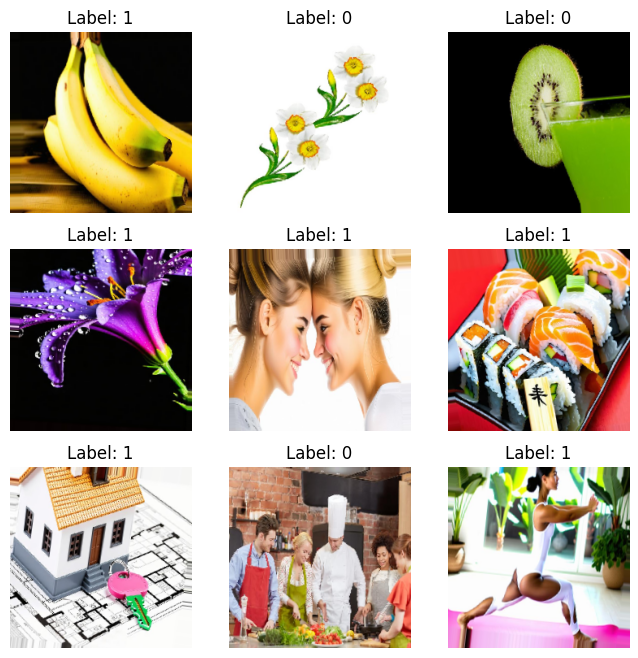

In [6]:
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_gen)

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {y_batch[i]}")
    plt.axis('off')
plt.show()


# Feature Maps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


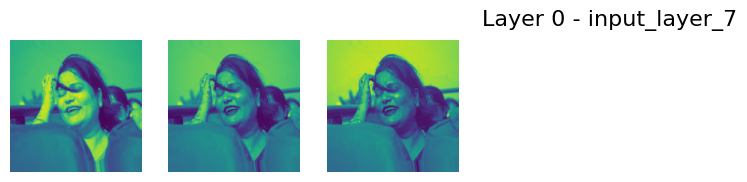

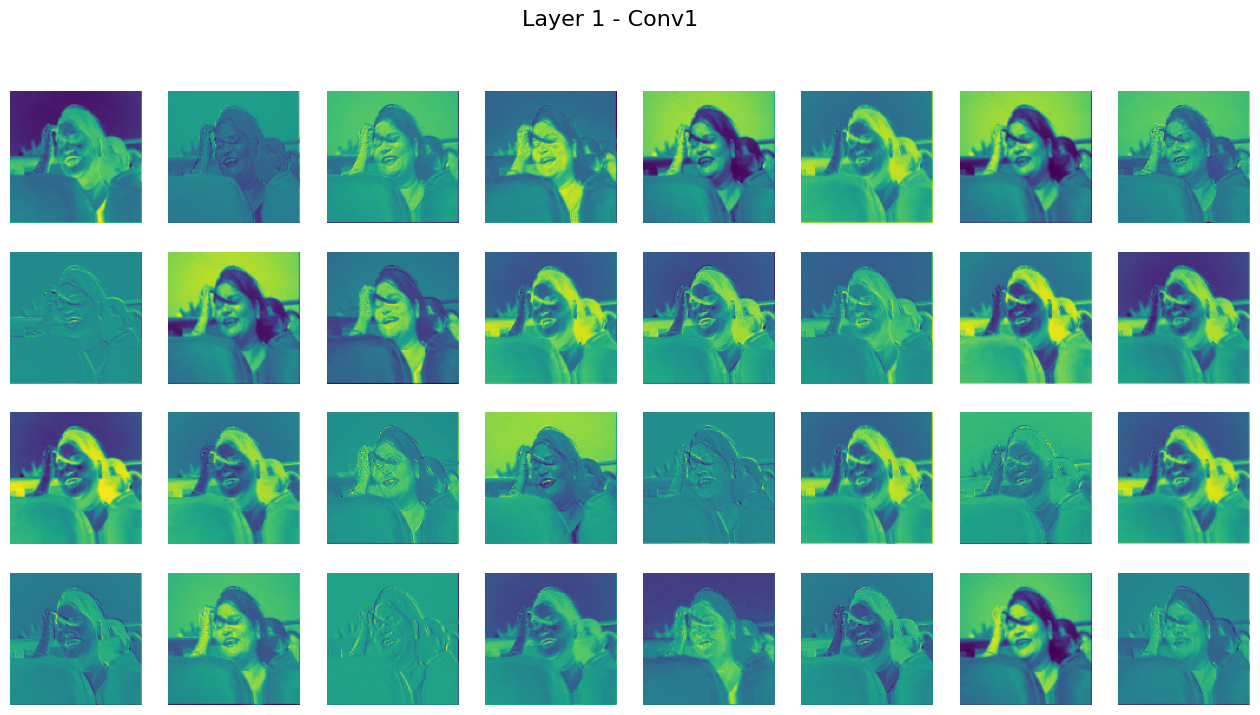

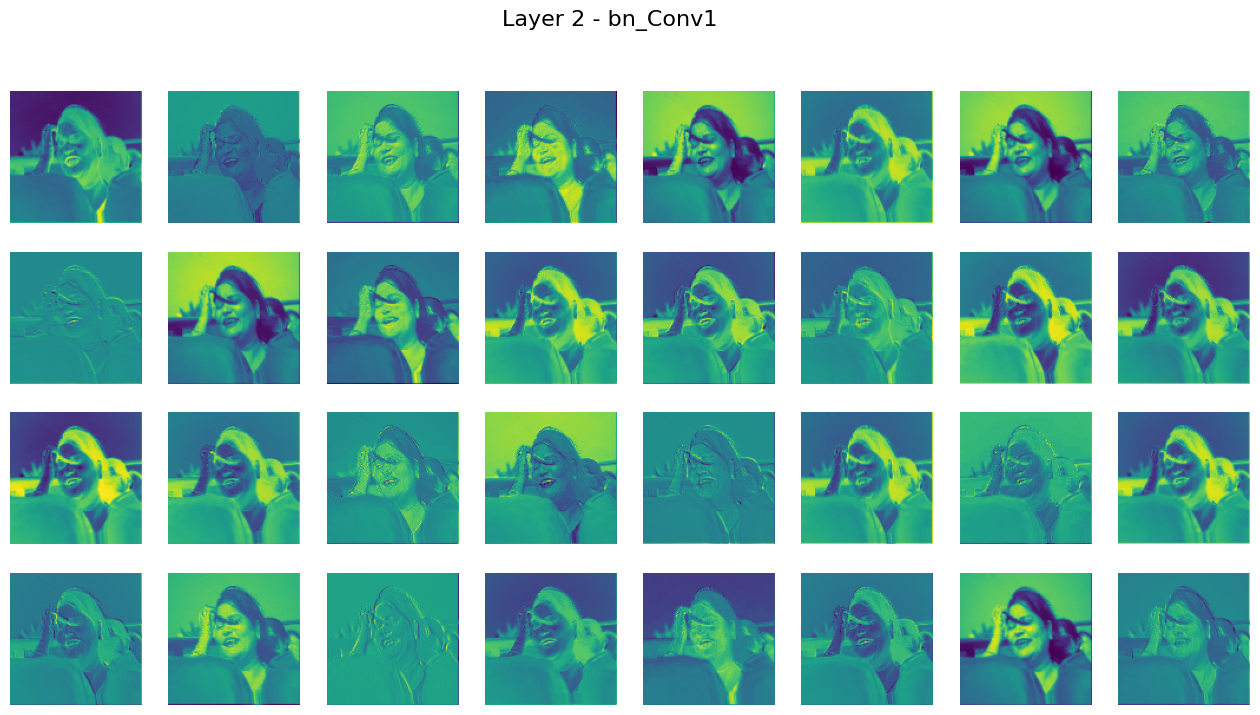

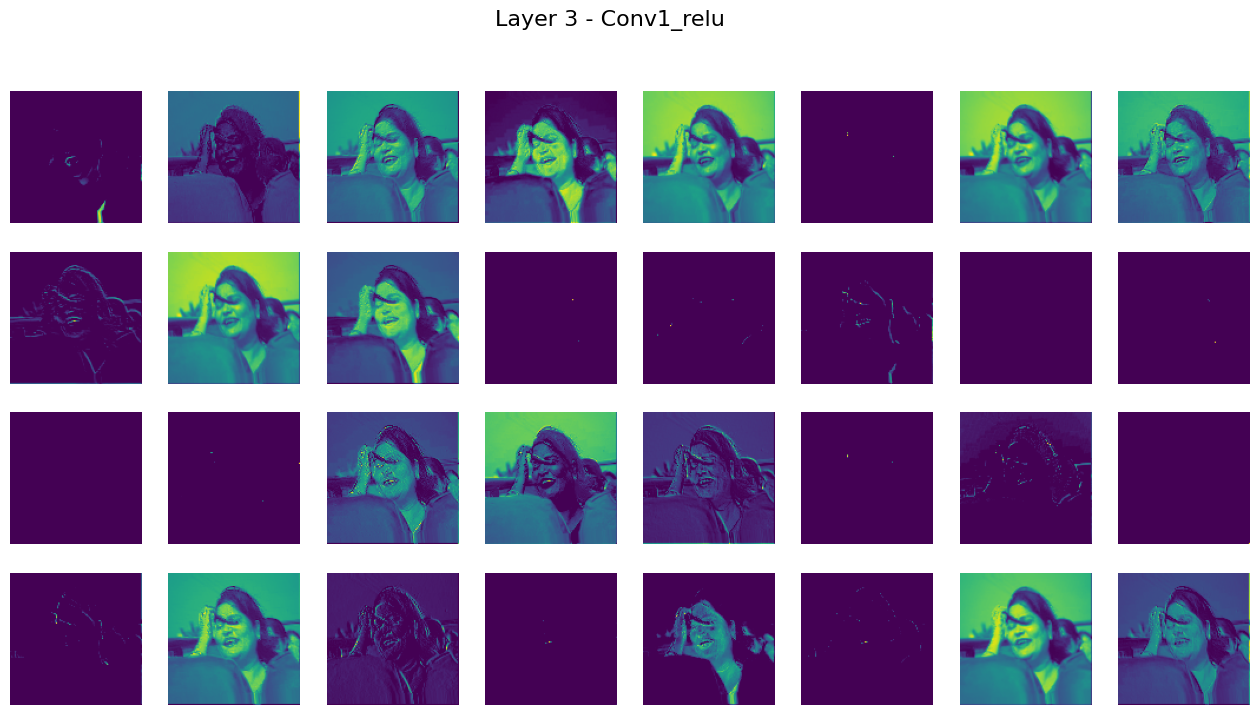

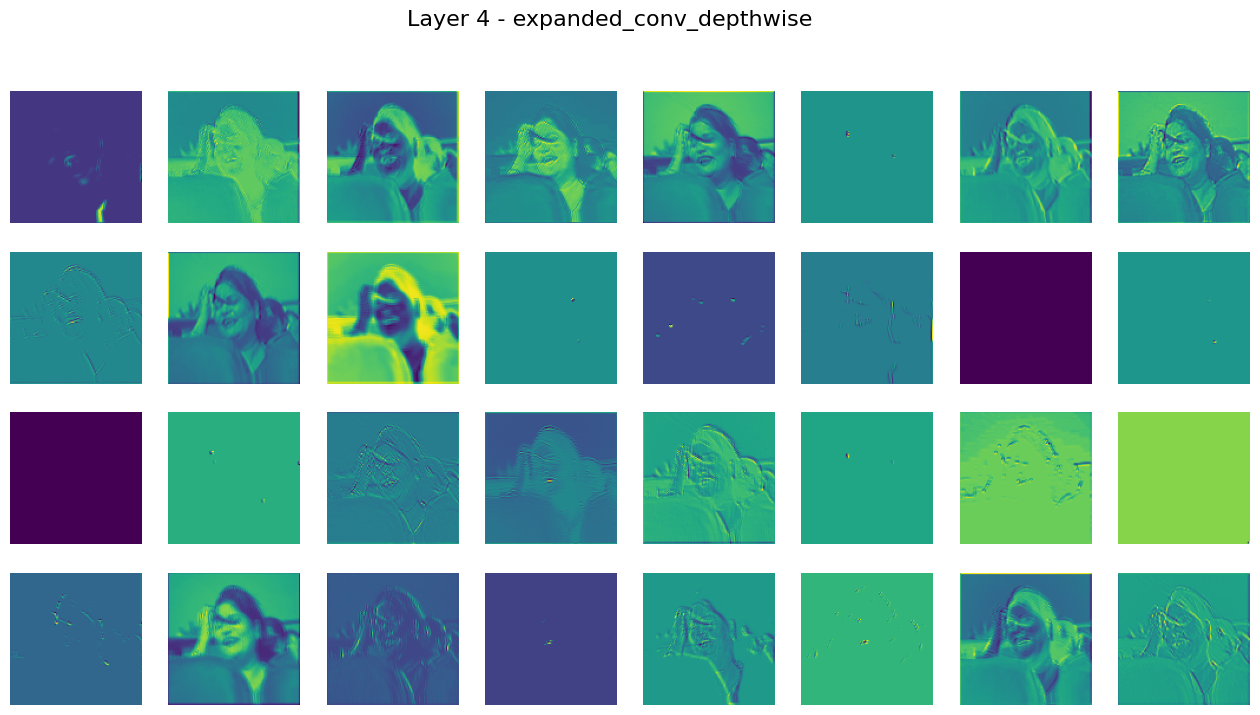

In [ ]:
import math

sample_img, _ = next(train_gen) 
img = sample_img[0:1]

num_layers_to_inspect = 5 
layer_outputs = [layer.output for layer in base_model.layers[:num_layers_to_inspect]]
activation_model = Model(inputs=base_model.input, outputs=layer_outputs)

activations = activation_model.predict(img)

for layer_idx, layer_activation in enumerate(activations):
    num_features = layer_activation.shape[-1]  
    size = layer_activation.shape[1]  
    
    cols = 8
    rows = math.ceil(num_features / cols)
    
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(num_features):
        plt.subplot(rows, cols, i+1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Layer {layer_idx} - {base_model.layers[layer_idx].name}', fontsize=16)
    plt.show()



## Explanation

The darker colors mean that there is low activation, so the filter is not identifying much information here. Brighter colors mean there is higher activation, so the filter is strongly detecting its pattern in that part of the image. 


### Layer 0: Input Layer

This is the raw input, nothing here is being computed. Just showing the RGB image with preprocessing. 

### Layer 1: First Convolutional Layer

Each channel shows where that filter identifies its pattern (brighter areas) and where it doesn't detect it (darker areas). Most of the layers are bright, so this layer is identifying a pattern. 

### Layer 2: Second Convolutional Layer (Batch Normalization)

This literally shows how the first convolutional layer is normalized. The maps are not flat, so it seems that this data preprocessing is working fairly well. 


### Layer 3: ReLU Activation Layer

This layer only lets positive evidence pass through, so we can see that a lot of the activations are 0 (dark regions). This means that the learning rate might not be working, or the initialization may be off. 


### Layer 4: Inverted Residual Block

This is part of MobileNetV2. There are many solid blocks of color here, but it does also seem to be identifying textures and objects fairly well. 


## Conclusions

While this visualization hasn't yet been applied on the model that is performing the best, this method may help to identify what layers are performing well and where to improve. 



# Grad-CAM Visualizations


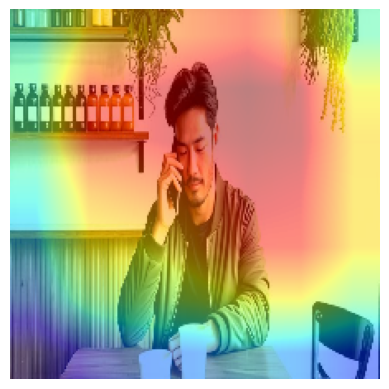

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(base_model, img_array, layer_name='Conv_1'):
    grad_model = tf.keras.models.Model(
        [base_model.inputs], 
        [base_model.get_layer(layer_name).output, base_model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]

    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.zeros(conv_outputs.shape[0:2], dtype=tf.float32)
    
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    cam = tf.maximum(cam, 0)
    cam = tf.image.resize(cam[..., tf.newaxis], (224, 224))  # resize
    cam = cam[..., 0]  # remove channel dim
    cam = cam - tf.reduce_min(cam)
    cam = cam / tf.reduce_max(cam)
    return cam.numpy()

# Apply Grad-CAM on first validation image
img = val_gen[0][0][0:1]
cam = grad_cam(base_model, img)

plt.imshow(img[0])
plt.imshow(cam, cmap='jet', alpha=0.5)  # overlay heatmap
plt.axis('off')
plt.show()


## Explanation

The point of this is to highlight what parts of the image are most important for the model. This uses the gradient of the predicted clasds score wrt the last layer's feature maps. The brighter areas (red or yellow) are the parts that the model thinks are the most relevant for the predicted class. The darker areas (blue or purple) are ignored in prediction.

## Conclusion

Here, the model is predicting using the subject of the photo, which is good. When applying this to the more accurate model, we can visualize which images have been misclassified and identify the parts of the photo being used to classify those particular images. If they are not intuitive, we can use that info for further fine-tuning. 

